In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch    


import sys
sys.path.append('..')

# reload in jupyter
%load_ext autoreload
%autoreload 2

from mix_NCA.utils_simulations import grid_to_channels_batch, train_nca_dyn, plot_nca_prediction, classification_update_net, plot_nca_prediction2, plot_automata_comparison_grid, classification_update_net_unorm
from mix_NCA.NCA import NCA 
from mix_NCA.MixtureNCA import MixtureNCA
from mix_NCA.TissueModel import ComplexCellType, TissueModel, create_complex_model_example, plot_cell_type_evolution
from mix_NCA.MixtureNCANoise import MixtureNCANoise


# seet seed
np.random.seed(3)


## Input generation

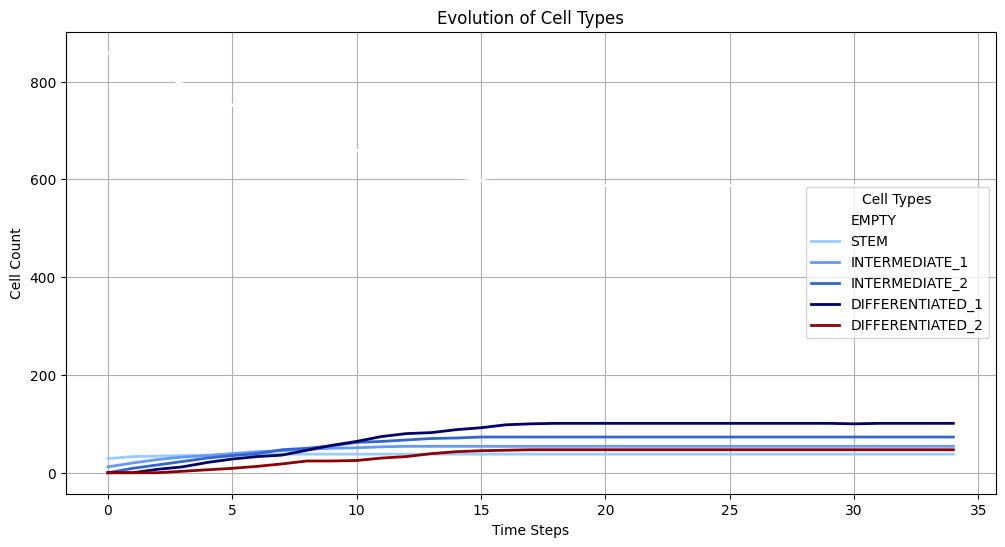

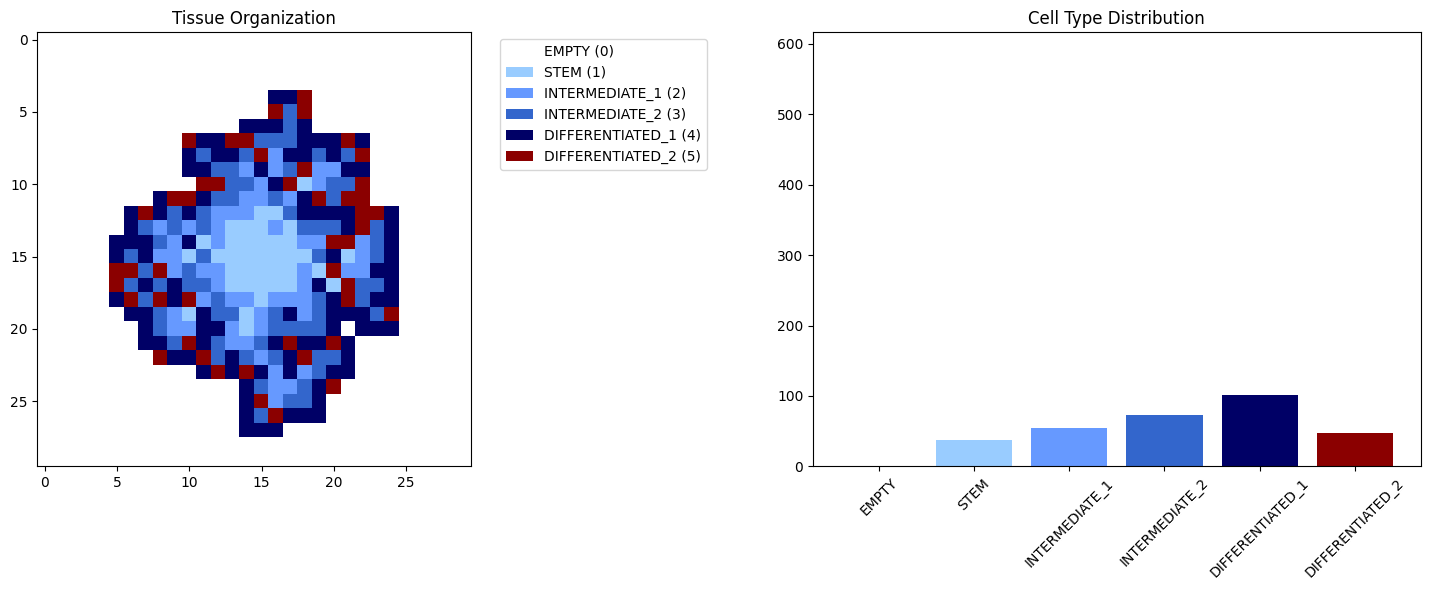

In [2]:
# Create and run model
model = create_complex_model_example(15)

# Run simulation
steps = 35
history = []
for _ in range(steps):
    model.step()
    history.append(model.grid.copy())

# Plot results
plot_cell_type_evolution(history)

# Plot final state
model.plot_tissue(show_statistics=True)

In [3]:
NSTEPS = 35
N_SIMULATIONS = 200
histories = []
spatial_models = []
for i in range(N_SIMULATIONS):
    n_stems = np.random.randint(5, high=15)
    model = create_complex_model_example(n_stems)
    history, _ = model.simulate(NSTEPS)
    histories.append(history)
    spatial_models.append(model)

In [4]:
# save the histories
np.save('histories.npy', histories)


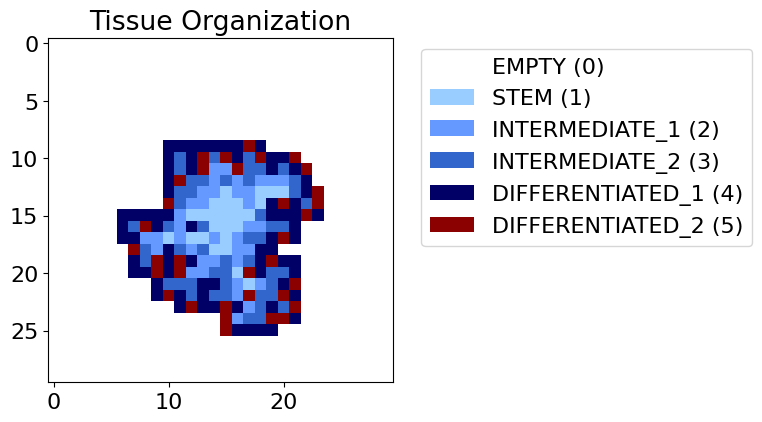

In [5]:
# change size of the plot and font size
plt.rcParams['figure.figsize'] = [30, 12]
plt.rcParams['font.size'] = 16

spatial_models[6].plot_tissue(show_statistics=False)

## Model training

In [6]:
histories = np.load("histories.npy")

In [7]:
nca = NCA(update_net = classification_update_net(6 * 3,  n_channels_out = 6), 
          hidden_dim = 128, maintain_seed = False, 
          use_alive_mask = False, state_dim = 6, residual = False)


In [8]:
train_nca_dyn(nca, histories,n_cell_types = 6, 
              n_epochs=800, time_length = 35,
                update_every = 1, device = "cuda:3", 
                lr = 0.001)

Precomputing grid representations...


Training NCA (mse): 100%|██████████| 800/800 [01:09<00:00, 11.49it/s, loss=0.001600, window=0-35]


0.056012782544712536

In [9]:
torch.save(nca.state_dict(), '../models/nca_biological_simulation.pth')


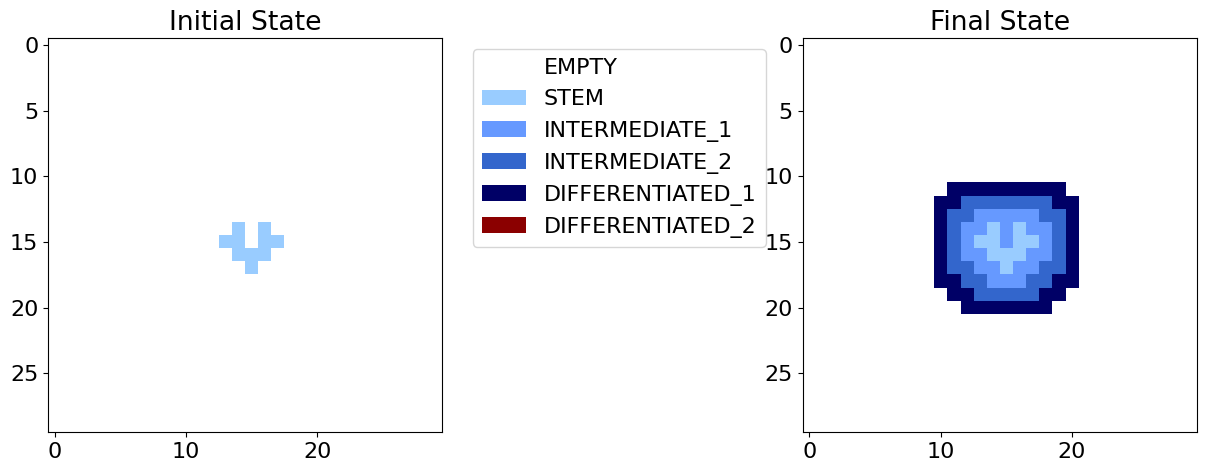

In [10]:
# Visualize the results
plot_nca_prediction(nca, histories[3][0],steps = 35,n_cell_types = 6, cell_type_enum = ComplexCellType, show_intermediate = False)

In [11]:
mix_nca = MixtureNCA(update_nets = classification_update_net, hidden_dim = 128, maintain_seed = False, use_alive_mask = False, state_dim = 6, num_rules = 5, residual = False, temperature = 3)

In [12]:
train_nca_dyn(model=mix_nca, target_states=histories,n_cell_types = 6, n_epochs=800, time_length = 35, update_every = 1, device = "cuda:3", lr = 0.001,  temperature = 5, min_temperature = 0.1, anneal_rate = 0.006, loss_type = "mse", straight_through = False)

Precomputing grid representations...


Training NCA (mse): 100%|██████████| 800/800 [06:34<00:00,  2.03it/s, loss=0.001601, window=0-35]


0.0560292391164694

In [13]:
torch.save(mix_nca.state_dict(), '../models/mix_nca_biological_simulation.pth')

In [14]:
mix_nca.temperature

3

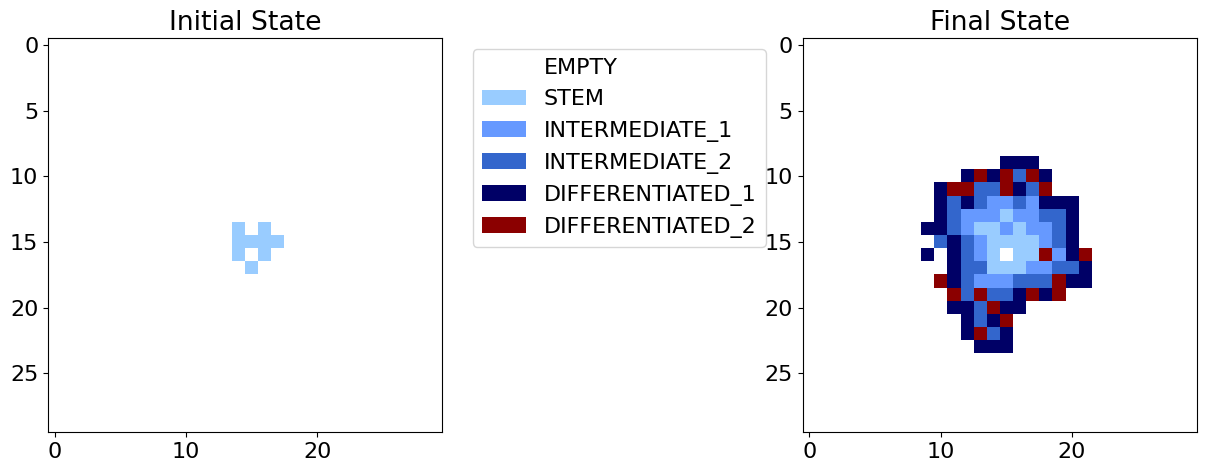

In [15]:
plot_nca_prediction(mix_nca, histories[30][0],steps =35,n_cell_types = 6, cell_type_enum = ComplexCellType , show_intermediate = False, random = True, random_seed = 42, device = "cuda:3")


In [29]:
stochastic_mix_nca = MixtureNCANoise(update_nets = classification_update_net, hidden_dim = 128, maintain_seed = False, use_alive_mask = False, state_dim = 6, num_rules = 5, residual = False, device = "cuda:3", temperature = 3)

In [30]:
train_nca_dyn(model=stochastic_mix_nca, target_states=histories,n_cell_types= 6, n_epochs=800, time_length = 35, update_every = 1, device = "cuda:3", lr = 0.001, milestones = [ 500], gamma = 0.1, temperature = 5, min_temperature = 0.1, anneal_rate = 0.006)


Precomputing grid representations...


Training NCA (mse): 100%|██████████| 800/800 [06:55<00:00,  1.92it/s, loss=0.001603, window=0-35]


0.05610133116715588

In [31]:
# save the model
torch.save(stochastic_mix_nca.state_dict(), '../models/stochastic_mix_nca_biological_simulation.pth')

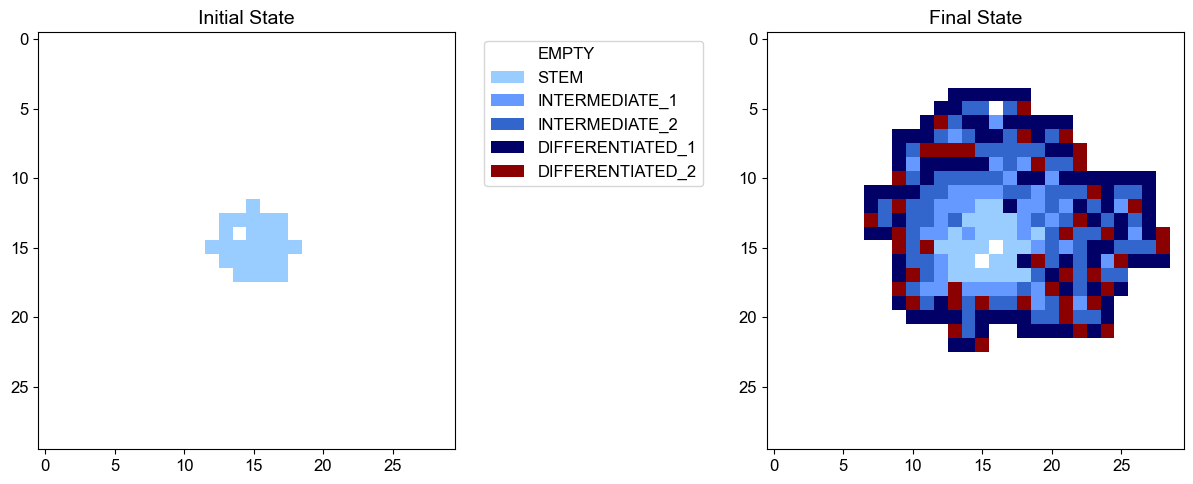

In [32]:


plot_nca_prediction(stochastic_mix_nca, initial_state=histories[10][0],cell_type_enum = ComplexCellType, n_cell_types= 6,steps=35,  show_intermediate = False, random = True, random_seed = 42, device = "cuda:3")

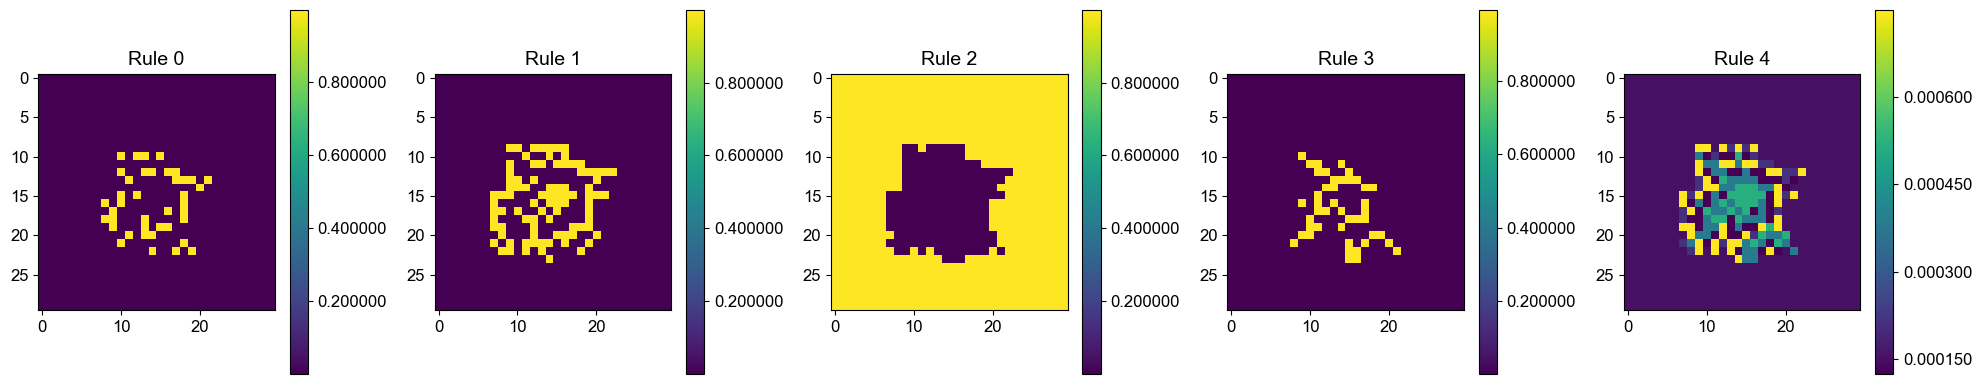

In [33]:

x = grid_to_channels_batch(grids=histories[3],     n_cell_types=6, device = "cuda:2")

stochastic_mix_nca.to("cuda:2")

_ = stochastic_mix_nca.visualize_rule_assignments(x[10:])

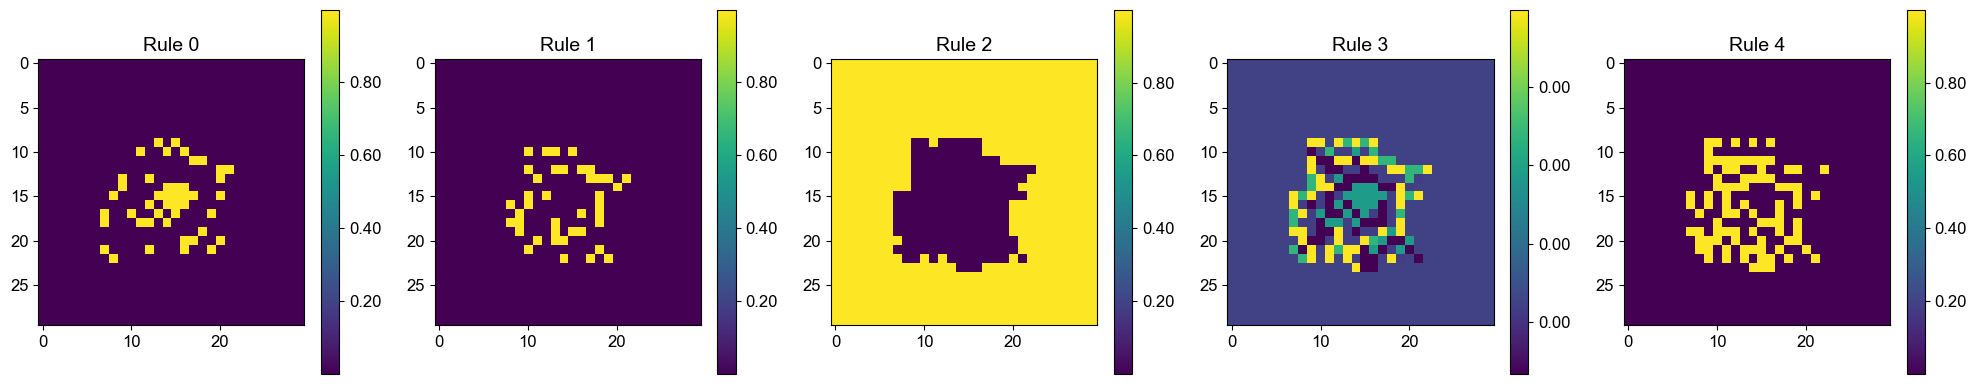

In [34]:
x = grid_to_channels_batch(grids=histories[3],     n_cell_types=6, device = "cuda:2")

mix_nca.to("cuda:2")

_ = mix_nca.visualize_rule_assignments(x[10:])

## Plot reconstruction results

In [6]:
histories = np.load("histories.npy")

In [7]:
# load the model
nca = NCA(update_net = classification_update_net(6 * 3,  n_channels_out = 6), hidden_dim = 128, maintain_seed = False, use_alive_mask = False, state_dim = 6, residual = False, device = "cuda:3")
nca.load_state_dict(torch.load('../models/nca_biological_simulation.pth', weights_only=True))

gca = NCA(update_net = classification_update_net(6 * 3,  n_channels_out = 6 * 2), hidden_dim = 128, maintain_seed = False, use_alive_mask = False, state_dim = 6, residual = False, distribution = "normal", device = "cuda:3")
gca.random_updates = True
gca.load_state_dict(torch.load('../models/nca_model_with_noise.pt', weights_only=True))


mix_nca = MixtureNCA(update_nets = classification_update_net, hidden_dim = 128, maintain_seed = False, use_alive_mask = False, state_dim = 6, num_rules = 5, residual = False, temperature = 3, device = "cuda:3")
mix_nca.load_state_dict(torch.load('../models/mix_nca_biological_simulation.pth', weights_only=True))

stochastic_mix_nca = MixtureNCANoise(update_nets = classification_update_net, hidden_dim = 128, maintain_seed = False, use_alive_mask = False, state_dim = 6, num_rules = 5, residual = False, temperature = 3, device = "cuda:3")
stochastic_mix_nca.load_state_dict(torch.load('../models/stochastic_mix_nca_biological_simulation.pth', weights_only=True))


mix_nca.eval()
stochastic_mix_nca.eval()
gca.eval()
nca.eval()

NCA(
  (update): Sequential(
    (0): Conv2d(18, 128, kernel_size=(1, 1), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 6, kernel_size=(1, 1), stride=(1, 1))
    (3): Softmax(dim=1)
  )
)

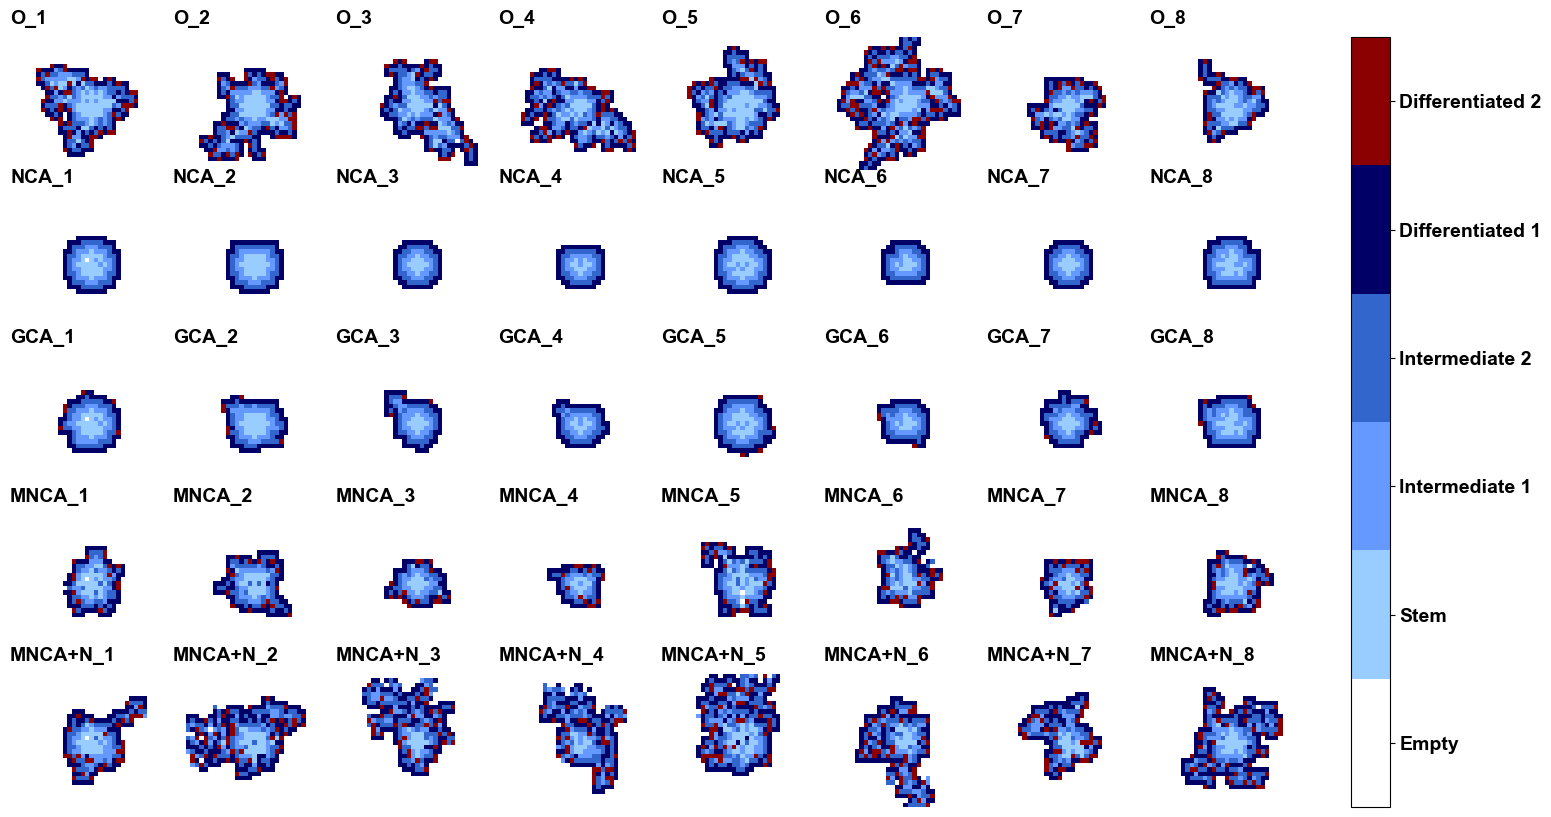

In [9]:
# Example usage:
fig = plot_automata_comparison_grid(
    det_nca=nca.to("cuda:3"),
    gca=gca.to("cuda:3"),
    mix_nca=mix_nca.to("cuda:3"),
    stoch_mix_nca=stochastic_mix_nca.to("cuda:3"),
    initial_state=histories,
    n_examples=8,
    n_steps=35,
    figsize=(18, 10) ,
    device = "cuda:3"
)

# Save the figure in high quality
fig.savefig('../figures/automata_comparison.png', bbox_inches='tight', dpi=300)
# For vector graphics (recommended for papers):
fig.savefig('automata_comparison.pdf', bbox_inches='tight', format='pdf')


<module 'matplotlib.pyplot' from '/home/salvatore.milite/miniconda3/envs/automata_project/lib/python3.11/site-packages/matplotlib/pyplot.py'>

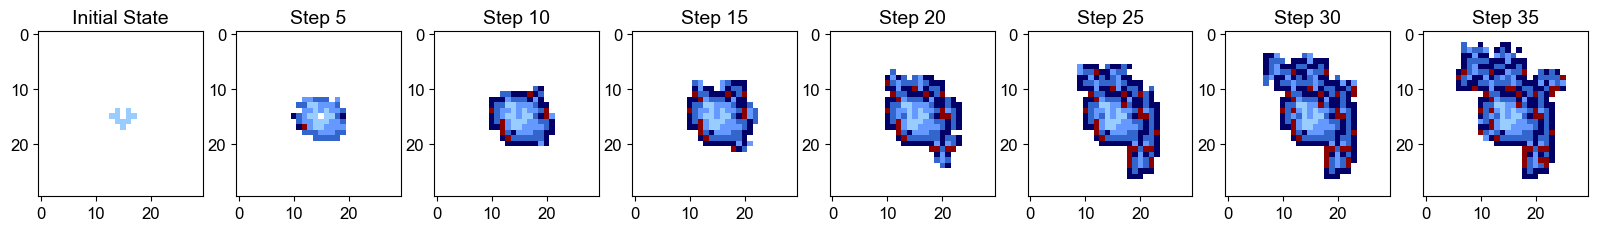

In [38]:
fig = plot_nca_prediction2(stochastic_mix_nca, histories[3][0], steps=35, plot_every=5, device = "cuda:3")


# Save the figure in high quality
fig.savefig('../figures/automata_prediction.png', bbox_inches='tight', dpi=300)
# For vector graphics (recommended for papers):
fig.savefig('../figures/automata_prediction.pdf', bbox_inches='tight', format='pdf')

## Rule assignment visualization

In [41]:
# load the histories    
histories = np.load("histories.npy")
x = grid_to_channels_batch(grids=histories[3],     n_cell_types=6, device = "cuda:3")

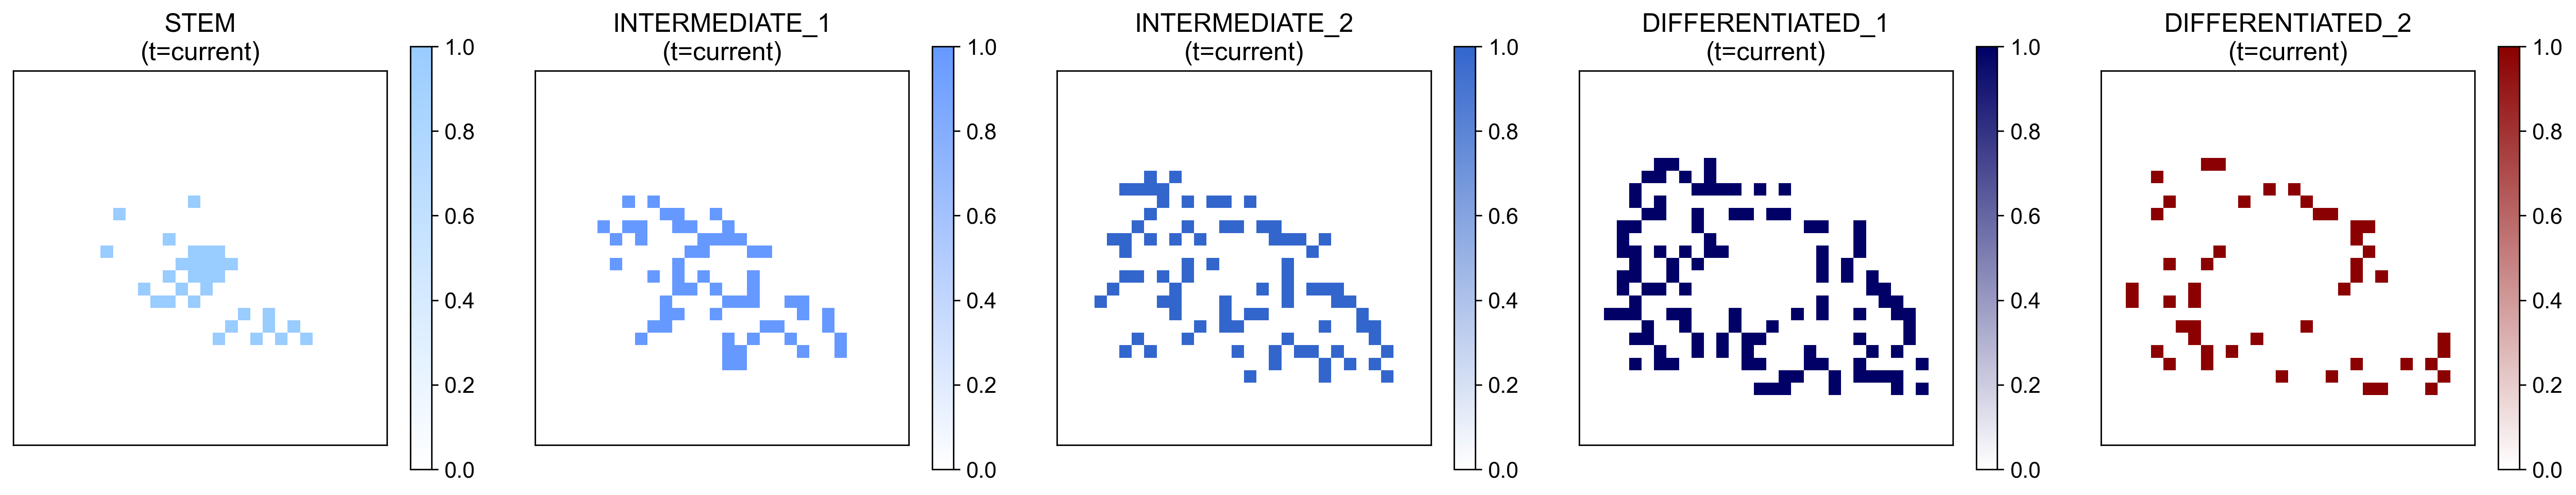

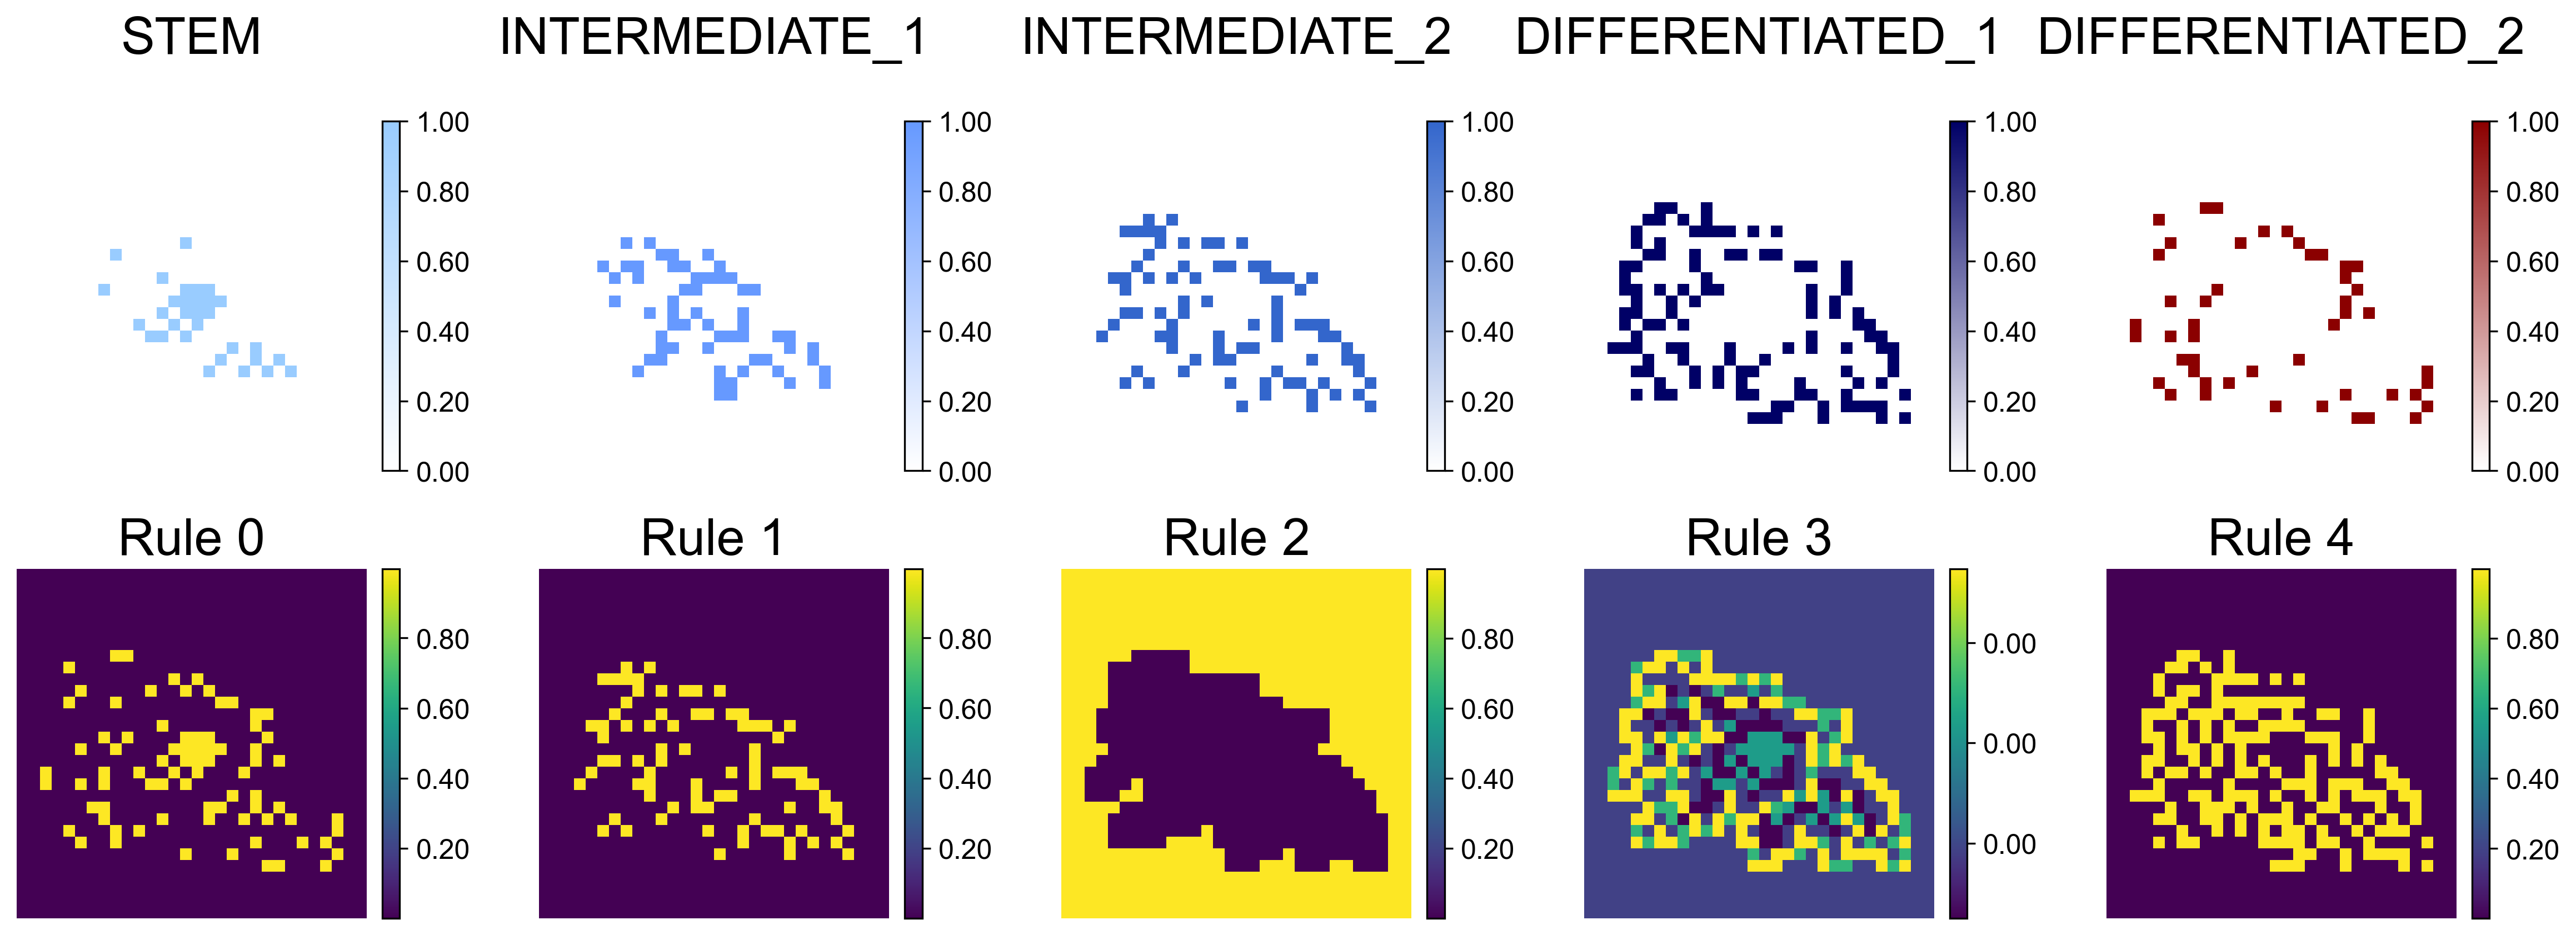

In [42]:
# Set figure visualization parameters
plt.rcParams['figure.dpi'] = 300
plt.rcParams['font.size'] = 22

# Get the original figures
fig1 = spatial_models[3].plot_grid(separate_types=True, skip_empty=True)
fig2 = mix_nca.visualize_rule_assignments(x[34:])

# Create a new figure with 2 rows and 5 columns
fig, axes = plt.subplots(2, 5, figsize=(16, 6))

cell_types = [ct for ct in ComplexCellType if ct != ComplexCellType.EMPTY]


# Transfer images from fig1 to top row
for i in range(5):
    # Get image data from original figure
    img_data = fig1.get_axes()[i].get_images()[0].get_array()
    # Plot in new figure
    cell_type = cell_types[i]
    color_map = plt.cm.colors.LinearSegmentedColormap.from_list(
                    f"custom_{cell_type.name}",
                    ['white', cell_type.get_color()]
                )
                
    im = axes[0, i].imshow(img_data, cmap=color_map)
    # remove current from the title string
    axes[0, i].set_title(fig1.get_axes()[i].get_title().replace('(t=current)', ''),  fontsize=22)
    axes[0, i].axis('off')
    plt.colorbar(im, ax=axes[0, i], format='%.2f', fraction=0.046, pad=0.04)

# Transfer images from fig2 to bottom row
for i in range(5):
    # Get image data from original figure
    img_data = fig2.get_axes()[i].get_images()[0].get_array()
    # Plot in new figure
    im = axes[1, i].imshow(img_data)
    axes[1, i].set_title(fig2.get_axes()[i].get_title(), fontsize=22)
    axes[1, i].axis('off')
    plt.colorbar(im, ax=axes[1, i], format='%.2f', fraction=0.046, pad=0.04)

plt.tight_layout()

# Save the figure
plt.savefig('../figures/spatial_model_and_rule_assignments.pdf', bbox_inches='tight', dpi=600, format='pdf')

# Close the original figures to free memory
plt.close(fig1)
plt.close(fig2)




## Test multiple time steps before update

In [2]:
np.random.seed(42)

# load histories
histories = np.load("histories.npy")


In [3]:
ncas = []
steps = [ i + 1 for i in range(0, 5, 1)]

for i in range(len(steps)):
    ncas.append(NCA(update_net = classification_update_net(6 * 3,  n_channels_out = 6), hidden_dim = 128, maintain_seed = False, use_alive_mask = False, state_dim = 6, residual = False))

for i in range(len(steps)):
    train_nca_dyn(ncas[i], histories,n_cell_types = 6, n_epochs=800, time_length = 35, update_every = steps[i], device = "cuda:3")

torch.save([nca.state_dict() for nca in ncas], "../models/ncas_update_every_test.pth")


Precomputing grid representations...


Training NCA (mse): 100%|██████████| 800/800 [01:19<00:00, 10.05it/s, loss=0.001600, window=0-35]


Precomputing grid representations...


Training NCA (mse): 100%|██████████| 800/800 [01:06<00:00, 12.08it/s, loss=0.001359, window=0-34]


Precomputing grid representations...


Training NCA (mse): 100%|██████████| 800/800 [01:03<00:00, 12.64it/s, loss=0.002572, window=1-34]


Precomputing grid representations...


Training NCA (mse): 100%|██████████| 800/800 [00:59<00:00, 13.53it/s, loss=0.007242, window=2-34]


Precomputing grid representations...


Training NCA (mse): 100%|██████████| 800/800 [01:03<00:00, 12.59it/s, loss=0.005945, window=0-35]


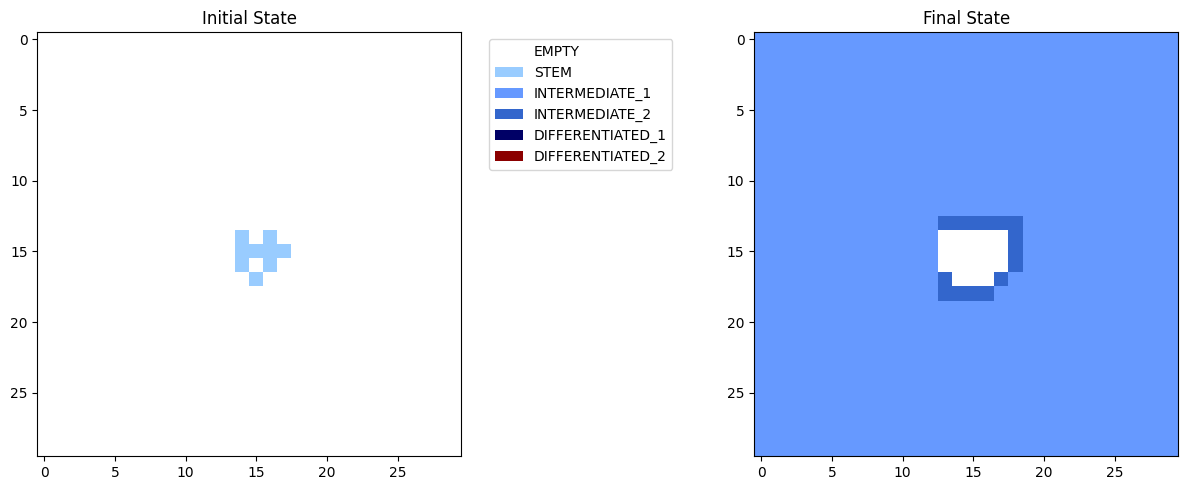

In [ ]:
# plot the results
plot_nca_prediction(ncas[1], histories[30][0], steps=4, n_cell_types=6, cell_type_enum=ComplexCellType, show_intermediate=False)


In [ ]:
ncas_mixture = []
steps = [ i + 1 for i in range(0, 5, 1)]

for i in range(len(steps)):
    ncas_mixture.append(MixtureNCA(update_nets = classification_update_net, hidden_dim = 128, maintain_seed = False, use_alive_mask = False, state_dim = 6, num_rules = 5, residual = False, temperature = 3))

for i in range(len(steps)):
    train_nca_dyn(ncas_mixture[i], histories,n_cell_types = 6, n_epochs=800, time_length = 35, update_every = steps[i], device = "cuda", lr = 0.001, milestones = [ 500], gamma = 0.1, temperature = 5, min_temperature = 0.1, anneal_rate = 0.006)

# save the list of state dictionaries
torch.save([nca.state_dict() for nca in ncas_mixture], "../models/ncas_mixture_update_every_test.pth")



Precomputing grid representations...


Training NCA (mse): 100%|██████████| 800/800 [06:55<00:00,  1.93it/s, loss=0.001601, window=0-35]


Precomputing grid representations...


Training NCA (mse):  73%|███████▎  | 583/800 [04:46<01:46,  2.04it/s, loss=0.001352, window=1-35]

In [33]:
ncas_mixture_stochastic = []
steps = [ i + 1 for i in range(0, 5, 1)]

for i in range(len(steps)):
    ncas_mixture_stochastic.append(MixtureNCANoise(update_nets = classification_update_net, hidden_dim = 128, maintain_seed = False, num_rules = 5, use_alive_mask = False, state_dim = 6, residual = False, temperature = 3))

for i in range(len(steps)):
    train_nca_dyn(ncas_mixture_stochastic[i], histories,n_cell_types = 6, n_epochs=800, time_length = 35, update_every = steps[i], device = "cuda",  lr = 0.001, milestones = [ 500], gamma = 0.1, temperature = 5, min_temperature = 0.1, anneal_rate = 0.006)

# save the ncas state dicts
torch.save([nca.state_dict() for nca in ncas_mixture_stochastic], "../models/ncas_mixture_stochastic_update_every_test.pth")


Training NCA (mse): 100%|██████████| 800/800 [14:37<00:00,  1.10s/it, loss=0.001444, window=0-35]


/tmp/ipykernel_466857/4277138600.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ncas_weights = torch.load("../models/ncas_update_every_test.pth")
/tmp/ipykernel_466857/

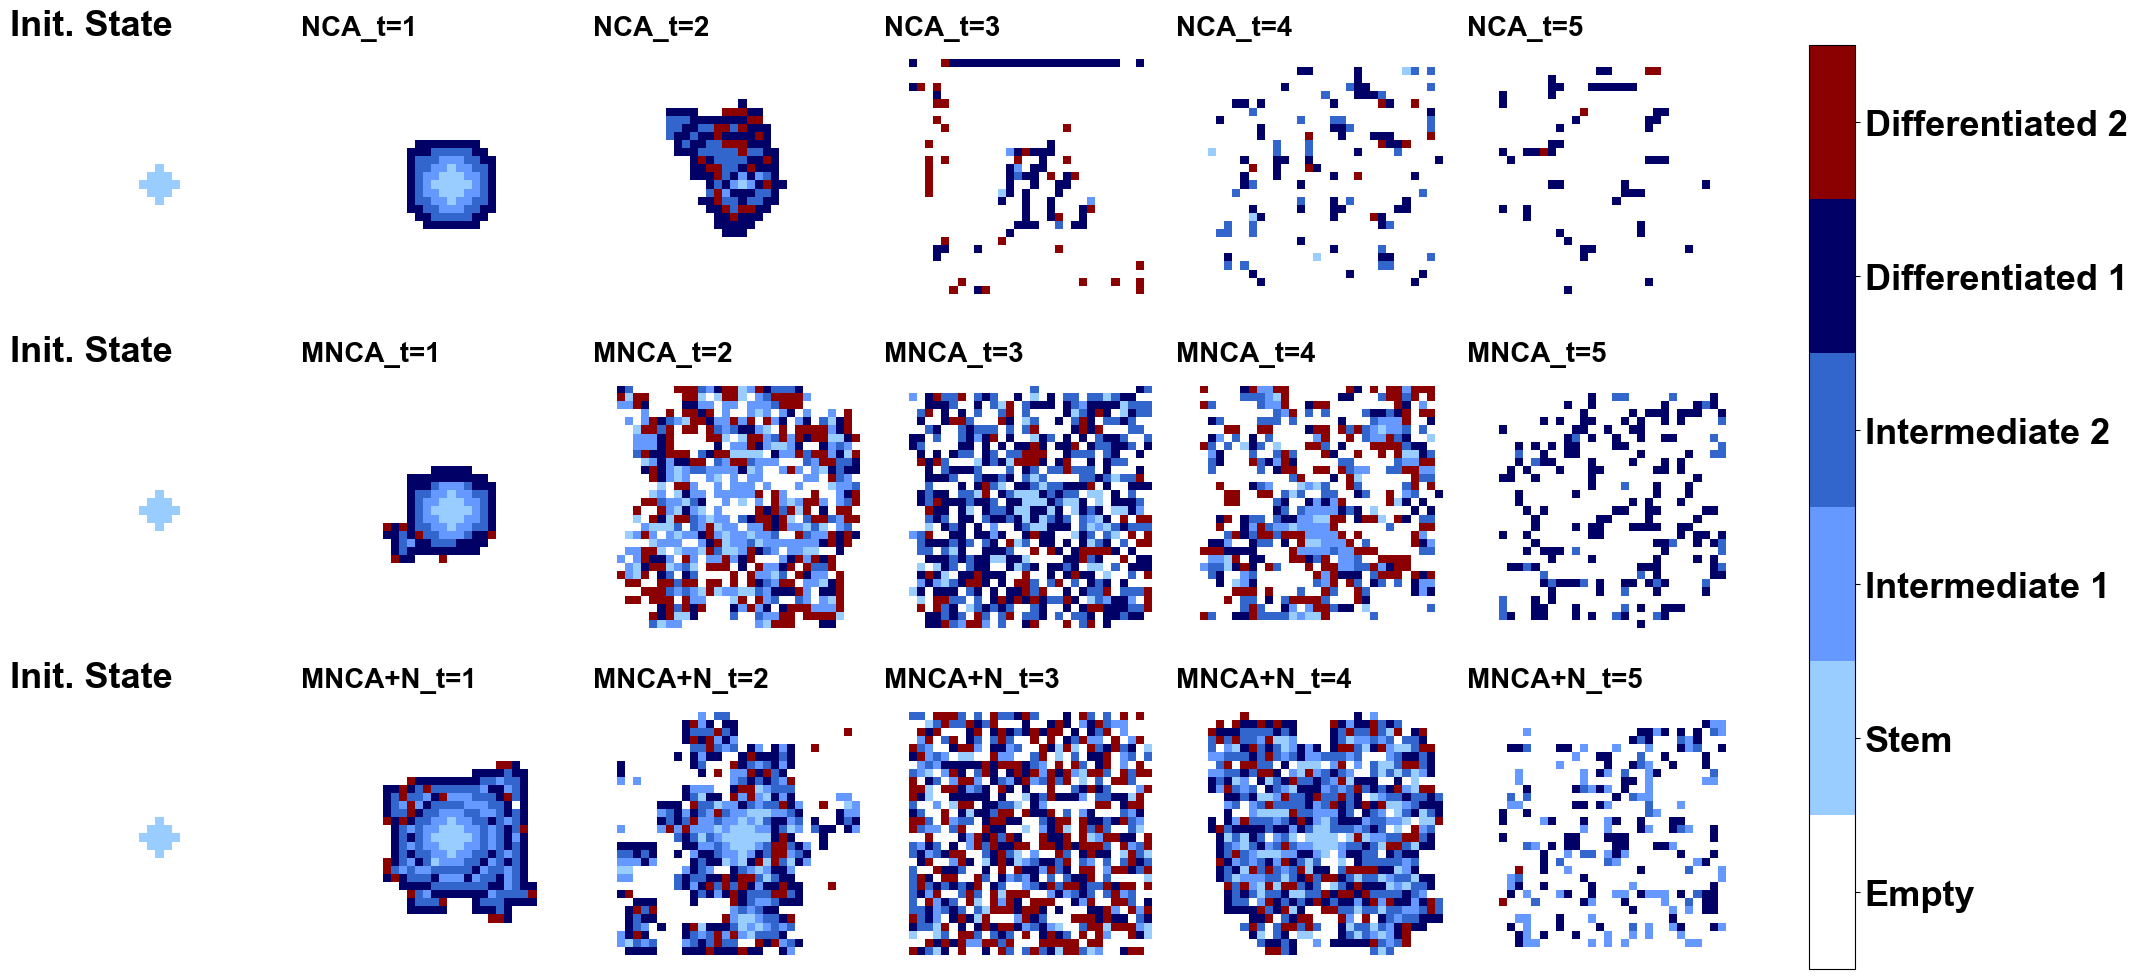

In [5]:
from matplotlib.font_manager import FontProperties
from matplotlib import colors as mcolors

# Load state dictionaries if needed
ncas_weights = torch.load("../models/ncas_update_every_test.pth")
ncas_mixture_weights = torch.load("../models/ncas_mixture_update_every_test.pth") 
ncas_mixture_stochastic_weights = torch.load("../models/ncas_mixture_stochastic_update_every_test.pth")

histories = np.load("histories.npy")

ncas = []
ncas_mixture = []
ncas_mixture_stochastic = []
steps = [ i + 1 for i in range(0, 5, 1)]

for i in range(len(steps)):
    ncas_mixture_stochastic.append(MixtureNCANoise(update_nets = classification_update_net, hidden_dim = 128, maintain_seed = False, num_rules = 5, use_alive_mask = False, state_dim = 6, residual = False))
    ncas_mixture_stochastic[i].load_state_dict(ncas_mixture_stochastic_weights[i])

for i in range(len(steps)):
    ncas_mixture.append(MixtureNCA(update_nets = classification_update_net, hidden_dim = 128, maintain_seed = False, num_rules = 5, use_alive_mask = False, state_dim = 6, residual = False))
    ncas_mixture[i].load_state_dict(ncas_mixture_weights[i])

for i in range(len(steps)):
    ncas.append(NCA(update_net = classification_update_net(6 * 3,  n_channels_out = 6), hidden_dim = 128, maintain_seed = False, use_alive_mask = False, state_dim = 6, residual = False))
    ncas[i].load_state_dict(ncas_weights[i])

torch.manual_seed(1)

# Set up the figure style
plt.style.use('default')
plt.rcParams.update({
    'font.family': 'Arial',
    'font.size': 20,
    'axes.labelsize': 20,
    'axes.titlesize': 20,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20
})

model_abbreviations = {
        0: 'NCA',
        1: 'MNCA',
        2: 'MNCA+N'
    }

# Create figure with grid layout
figsize=(24, 12)
fig, axes = plt.subplots(3, 6, figsize=figsize)
# Get initial state
initial_state = histories[3][0]
font_size = 26

final_steps = [35,34,33,32,35]

# Create custom colormap
colors = [cell_type.get_color() for cell_type in ComplexCellType]
custom_cmap = mcolors.ListedColormap(colors)


# Add subplot labels and plot content
for row in range(3):
    
    for col in range(6):
        ax = axes[row, col]
        
        # Add subplot labels (A1, A2, A3, B1, B2, B3, etc.)
        
        
        if col == 0:
            # Plot original state
            label = f'Init. State'
            ax.text(-0.1, 1.1, label, transform=ax.transAxes, 
                        fontsize=font_size, fontweight='bold')
            ax.imshow(
                initial_state,
                cmap=custom_cmap,
                vmin=0,
                vmax=len(ComplexCellType)-1
            )
        else:
            # Run simulation and plot results
            with torch.no_grad():
                torch.manual_seed(col)
                current_state = grid_to_channels_batch([initial_state], n_cell_types = 6, device = "cuda")
                if row == 1:
                    for i in range(final_steps[col-1]):
                        current_state = ncas_mixture[col-1](current_state, 1, return_history=False, sample_rule = True)

                elif row == 2:
                    for i in range(final_steps[col-1]):
                        current_state = ncas_mixture_stochastic[col-1](current_state, 1, return_history=False, sample_rule = True)


                else:
                    for i in range(final_steps[col-1]):
                        current_state = ncas[col-1](current_state, 1, return_history=False)

                label = f'{model_abbreviations[row]}_t={col}'
                ax.text(-0.1, 1.1, label, transform=ax.transAxes, 
                        fontsize=20, fontweight='bold')
                ax.imshow(
                    torch.argmax(current_state.squeeze(), dim=0).cpu(),
                    cmap=custom_cmap,
                    vmin=0,
                    vmax=len(ComplexCellType)-1
                )
        ax.axis('off')

# Add colorbar with improved styling
norm = plt.Normalize(vmin=-0.5, vmax=len(ComplexCellType)-0.5)
sm = plt.cm.ScalarMappable(cmap=custom_cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=axes.ravel().tolist(), fraction=0.046, pad=0.04)
cbar.set_ticks(range(len(ComplexCellType)))
cbar.set_ticklabels([ct.name.replace('_', ' ').title() for ct in ComplexCellType])
cbar.ax.tick_params(labelsize=font_size)
for tick in cbar.ax.yaxis.get_major_ticks():
    tick.label2.set_fontweight('bold')
cbar.set_label('', fontsize=20, fontweight='bold')

plt.show()

# save the figure
#fig.savefig('../figures/update_every_test.pdf', bbox_inches='tight', dpi=600, format='pdf')



## Test rule number effect


In [43]:
# Test different numbers of rules
n_rules_list = [1,2,3,4,5,6,7,8]
n_epochs = 800
time_length = 35
update_every = 1
n_cell_types = 6
device = "cuda"


# Initialize models and train for each number of rules
for col, n_rules in enumerate(n_rules_list):
    # Create and train mixture model
    mixture_model = MixtureNCA(update_nets = classification_update_net, hidden_dim = 128, maintain_seed = False, use_alive_mask = False, state_dim = 6, num_rules = n_rules, residual = False)
    train_nca_dyn(mixture_model, target_states=histories, n_cell_types=n_cell_types, 
                  time_length=time_length, n_epochs=n_epochs, device=device,
                  update_every=update_every, temperature = 5, min_temperature = 0.1, anneal_rate = 0.006, loss_type = "mse", straight_through = False)
    
    # Create and train stochastic mixture model  
    mixture_stochastic_model = MixtureNCANoise(update_nets = classification_update_net, hidden_dim = 128, maintain_seed = False, use_alive_mask = False, state_dim = 6, num_rules = n_rules, residual = False)
    train_nca_dyn(mixture_stochastic_model, histories, n_cell_types=n_cell_types,
                  time_length=time_length, n_epochs=n_epochs, device=device, 
                  update_every=update_every, temperature = 5, min_temperature = 0.1, anneal_rate = 0.006, loss_type = "mse", straight_through = False)
    
    # save the models
    torch.save(mixture_model.state_dict(), f"../models/mixture_model_n_rules_{n_rules}.pth")
    torch.save(mixture_stochastic_model.state_dict(), f"../models/mixture_stochastic_model_n_rules_{n_rules}.pth")


Precomputing grid representations...


Training NCA (mse): 100%|██████████| 800/800 [13:00<00:00,  1.03it/s, loss=0.001712, window=0-35]


Precomputing grid representations...


Training NCA (mse): 100%|██████████| 800/800 [08:23<00:00,  1.59it/s, loss=0.001711, window=0-35]


Precomputing grid representations...


Training NCA (mse): 100%|██████████| 800/800 [06:40<00:00,  2.00it/s, loss=0.001713, window=0-35]


Precomputing grid representations...


Training NCA (mse): 100%|██████████| 800/800 [07:25<00:00,  1.80it/s, loss=0.001713, window=0-35]


Precomputing grid representations...


Training NCA (mse): 100%|██████████| 800/800 [06:59<00:00,  1.90it/s, loss=0.001710, window=0-35]


Precomputing grid representations...


Training NCA (mse):   5%|▍         | 37/800 [00:22<07:50,  1.62it/s, loss=0.002497, window=0-35]